In [2]:
import os
root_dir = os.path.abspath('..')

In [154]:
import numpy as np
import nibabel as nib
import matplotlib
import matplotlib.pyplot as plt
from scipy.misc import imresize
%matplotlib inline

def fetch_data(base_dir,num_subjects):
    '''Load in simulated data and motion files.'''
    subject_list = os.listdir((os.path.join(base_dir)))
    subject_list = [item for item in subject_list if item.startswith('.') == False] #Filter .DS_STORE
    counter = 0
    X = np.zeros((108*num_subjects,72,86,55))
    y = np.zeros(108*num_subjects)
    X_subject = np.zeros((72,86,55,108))
    y_subject = np.zeros(108)
    for subject_index, subject_number in enumerate(subject_list):
        data_path = os.path.join(base_dir,subject_number,'data.nii.gz')
        if os.path.isfile(data_path):
            data_header = nib.load(data_path)
            X_subject = data_header.get_data()
            for i in range(108):
                motion = np.loadtxt(os.path.join(base_dir,subject_number,'motion/motion'+str(i)+'.txt'))
                y_subject[i] = create_labels(motion)
            start_index = counter*108
            end_index = (counter+1)*108
            X[start_index:end_index,:] = np.moveaxis(X_subject,3,0)
            y[start_index:end_index] = y_subject
            counter += 1
    return X,y

def create_labels(motion, translation_threshold=1, rotation_threshold = 1):
    '''Take a POSSUM motion file and decide whether it contains signficant intra-volume movement.'''
    max_motion = np.max(motion[:,1:],axis=0)
    min_motion = np.min(motion[:,1:],axis=0)
    diff_motion = np.abs(max_motion-min_motion)
    diff_motion[:3] = diff_motion[:3]*1000
    diff_motion[3:] = np.rad2deg(diff_motion[3:])
    if np.any( diff_motion[:3] > translation_threshold):
        return 1
    elif np.any(diff_motion[3:] > rotation_threshold):
        return 1
    else:
        return 0
    
def plot_volumes(X,y):
    X = np.moveaxis(X,0,3)
    num_volumes = 10
    plt.figure(figsize=(10,120))
    slices = [43,36,26]
    pad_max = np.max(X.shape[:3])
    for i in range(num_volumes):
        for j in range(3):
            plt.subplot(num_volumes,3,i*3+j+1)
            if j == 0:
                im = pad_image(np.squeeze(X[:,:,slices[j],i]),pad_max)
                plt.imshow(np.rot90(im),plt.cm.get_cmap('gray'))
                plt.title(y[i])
            if j == 1:
                im = pad_image(np.squeeze(X[:,slices[j],:,i]),pad_max)
                plt.imshow(np.rot90(im),plt.cm.get_cmap('gray'))
            if j == 2:
                im = pad_image(np.squeeze(X[slices[j],:,:,i]),pad_max)
                plt.imshow(np.rot90(im),plt.cm.get_cmap('gray'))
            plt.axis('off')
    plt.tight_layout()
                     
def pad_image(image,pad_max):
    pad_width = np.array([[pad_max,pad_max],[pad_max,pad_max]])-[image.shape,image.shape]
    pad_width=np.transpose(pad_width)
    pad_width[:,0] = np.floor(pad_width[:,0]/2)
    pad_width[:,1] = np.ceil(pad_width[:,1]/2)
    return np.lib.pad(image,pad_width,'constant',constant_values=(0))



def preprocess_data_perp(X,target_height=299,target_width=299):
    '''Performs minimal pre-processing: convert each MR volume to a stack of 3 
    orthogonal planes, scale the data and resample to 299 by 299 pixels'''   
    slices = [26,36,26] #Planes to slice
    pad_max = np.max(X.shape[1:]) #Width to pad images to
    num_volumes = X.shape[0]
    X_preprocessed = np.zeros((num_volumes,target_height,target_width,3))
    for i in range(num_volumes):
        for j in range(3):
            if (j == 0):
                X_preprocessed[i,:,:,j] = imresize(pad_image(np.squeeze(X[i,:,:,slices[j]]),pad_max),(target_width,target_height))
            if (j == 1):
                X_preprocessed[i,:,:,j] = imresize(pad_image(np.squeeze(X[i,:,slices[j],:]),pad_max),(target_width,target_height))
            if (j == 2):
                X_preprocessed[i,:,:,j] = imresize(pad_image(np.squeeze(X[i,slices[j],:,:]),pad_max),(target_width,target_height))     
                
    return X_preprocessed.astype(np.float32) / 255

def preprocess_data_planar(X,target_height=299,target_width=299,is_training=False):
    '''Performs minimal pre-processing: convert each MR volume to a stack of 3 
    orthogonal planes, scale the data and resample to 299 by 299 pixels'''   
    #slices = [22,36,50] #Planes to slice
    slices = np.array([36,36,36]) #Planes to slice
    pad_max = np.max(X.shape[2:]) #Width to pad images to
    num_volumes = X.shape[0]
    X_preprocessed = np.zeros((num_volumes,target_height,target_width,3))
    if is_training == True:
        slices_new = slices + np.random.randint(-4,4)
        for i in range(num_volumes):
            for j in range(3):
                if (j == 0):
                    X_preprocessed[i,:,:,j] = imresize(pad_image(np.squeeze(X[i,slices_new[j],:,:]),pad_max),(target_width,target_height))
                if (j == 1):
                    X_preprocessed[i,:,:,j] = imresize(pad_image(np.squeeze(X[i,slices_new[j],:,:]),pad_max),(target_width,target_height))
                if (j == 2):
                    X_preprocessed[i,:,:,j] = imresize(pad_image(np.squeeze(X[i,slices_new[j],:,:]),pad_max),(target_width,target_height))     
                    
    else: 
        for i in range(num_volumes):
            for j in range(3):
                if (j == 0):
                    X_preprocessed[i,:,:,j] = imresize(pad_image(np.squeeze(X[i,slices[j],:,:]),pad_max),(target_width,target_height))
                if (j == 1):
                    X_preprocessed[i,:,:,j] = imresize(pad_image(np.squeeze(X[i,slices[j],:,:]),pad_max),(target_width,target_height))
                if (j == 2):
                    X_preprocessed[i,:,:,j] = imresize(pad_image(np.squeeze(X[i,slices[j],:,:]),pad_max),(target_width,target_height))     
                
    return X_preprocessed.astype(np.float32) / 255

## Load in data

In [4]:
from sklearn.model_selection import train_test_split

X, y = fetch_data(os.path.join(root_dir,'data/sims'),8)
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,random_state=42) 


## Train

In [155]:
#Set up the inception v3 on data by stacking 3 perpendicular slices
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

tf.reset_default_graph()

num_outputs = 2

X = tf.placeholder(tf.float32, shape=(None, 299, 299, 3),name="X") 
y = tf.placeholder(tf.int64, shape=(None), name="y")


with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(X, num_classes=1001, is_training=False)

#Define the scopes that you want to exclude for restoration
exclude = ['InceptionResnetV3/Logits', 'InceptionResnetV3/AuxLogits']
variables_to_restore = slim.get_variables_to_restore(exclude = exclude)
saver = tf.train.Saver(variables_to_restore)

with tf.Session() as sess:
    #saver.restore(sess,'models/inception_v3.ckpt');   
    last_layer = logits.op.inputs[0].op.inputs[0].op.inputs[0]
    last_layer_squeezed = tf.squeeze(last_layer,axis=[1,2])
    with tf.name_scope("output"):
        he_init = tf.contrib.layers.variance_scaling_initializer() #use the He initialisation scheme
        logits = fully_connected(last_layer_squeezed,num_outputs,activation_fn=None,weights_initializer = he_init,scope="logits")
        softmax_score = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits)
        loss = tf.reduce_mean(softmax_score,name="loss")
    with tf.name_scope("train"):
        #optimizer = tf.train.MomentumOptimizer(learning_rate=0.01,momentum=0.95)
        optimizer = tf.train.AdamOptimizer()
        #train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope="InceptionV3/Mixed_7c/|logits")
        train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope="logits")
        training_op = optimizer.minimize(loss,var_list=train_vars)
    with tf.name_scope("eval"):   
        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))    
    init = tf.global_variables_initializer()

In [160]:
#More set up
import time
preprocess_function = preprocess_data_planar
X_test_preprocessed = preprocess_function(X_test)

num_epochs = 151
train_size = X_train_preprocessed.shape[0]
batch_size = 20
num_batches = np.floor(train_size / batch_size).astype(np.int16)

def get_batch(X,y,batch_size,batch_index):
    start_index = batch_index * batch_size
    end_index = (batch_index + 1) * batch_size
    return X[start_index:end_index,:], y[start_index:end_index]
    

In [161]:
#Train
with tf.Session() as sess:
    sess.run(init)
    saver.restore(sess,'models/inception_v3.ckpt');   
    for epoch in range(num_epochs):
        t0=time.time()
        for index in range(num_batches):
            X_batch, y_batch = get_batch(X_train,y_train,batch_size,index)
            X_batch_preprocessed = preprocess_function(X_batch,299,299,True)
            sess.run(training_op,feed_dict={X:X_batch_preprocessed,y:y_batch})
        #Test accuracy on roughly half of train set (for memory issues) and full test set 
        if epoch % 5 == 0:
            X_batch, y_batch = get_batch(X_train,y_train,400,0)    
            X_batch_preprocessed = preprocess_function(X_batch)
            acc_train = accuracy.eval(feed_dict={X: X_batch_preprocessed, y: y_batch})
            loss_train = loss.eval(feed_dict={X: X_batch_preprocessed, y: y_batch})
            acc_test = accuracy.eval(feed_dict={X: X_test_preprocessed, y: y_test})
            t1=time.time()
            print('Epoch:',epoch,'train loss:',loss_train,"train acc:", acc_train,"val acc:", acc_test,"time:",t1-t0)
        else:
            t1=time.time()
            print('Epoch:',epoch,"time:",t1-t0) 
    print("Training finished.")
    test_logits = logits.eval(feed_dict={X: X_test_preprocessed, y: y_test})

INFO:tensorflow:Restoring parameters from models/inception_v3.ckpt
Epoch: 0 train loss: 0.49811 train acc: 0.805 val acc: 0.731481 time: 14.630508184432983
Epoch: 1 time: 7.800334930419922
Epoch: 2 time: 7.438775300979614
Epoch: 3 time: 6.900479555130005
Epoch: 4 time: 7.002554178237915
Epoch: 5 train loss: 0.423775 train acc: 0.8075 val acc: 0.763889 time: 14.234485626220703
Epoch: 6 time: 6.611053705215454
Epoch: 7 time: 7.344398736953735
Epoch: 8 time: 7.434592247009277
Epoch: 9 time: 7.5754523277282715
Epoch: 10 train loss: 0.35741 train acc: 0.8525 val acc: 0.814815 time: 13.169607162475586
Epoch: 11 time: 7.281236886978149
Epoch: 12 time: 7.0499587059021
Epoch: 13 time: 7.531679153442383
Epoch: 14 time: 6.616507291793823
Epoch: 15 train loss: 0.366747 train acc: 0.85 val acc: 0.796296 time: 13.478400230407715
Epoch: 16 time: 7.807253360748291
Epoch: 17 time: 6.900139570236206
Epoch: 18 time: 6.567044019699097
Epoch: 19 time: 7.268167972564697
Epoch: 20 train loss: 0.368058 train 

## Visualise

In [162]:
from sklearn.metrics import accuracy_score, confusion_matrix
from matplotlib import animation
from matplotlib import animation, rc
from IPython.display import HTML

predictions = np.argmax(np.exp(test_logits)/np.sum(np.exp(test_logits),1,keepdims=True),1)
print(accuracy_score(y_test,predictions))
print(confusion_matrix(y_test,predictions))

ind_true_pos = [indx for indx,y in enumerate(y_test) if (y_test[indx] == 1) and (predictions[indx] == 1) ]
ind_true_neg = [indx for indx,y in enumerate(y_test) if (y_test[indx] == 0) and (predictions[indx] == 0) ]
ind_false_neg = [indx for indx,y in enumerate(y_test) if (y_test[indx] == 1) and (predictions[indx] == 0) ]
ind_false_pos = [indx for indx,y in enumerate(y_test) if (y_test[indx] == 0) and (predictions[indx] == 1) ]

0.87962962963
[[152   8]
 [ 18  38]]


In [164]:
fig=plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

image1 = ax1.imshow(np.zeros((X_test_preprocessed.shape[1],X_test_preprocessed.shape[2],3))); ax1.axis('off')
image2 = ax2.imshow(np.zeros((X_test_preprocessed.shape[1],X_test_preprocessed.shape[2],3))); ax2.axis('off')
image3 = ax3.imshow(np.zeros((X_test_preprocessed.shape[1],X_test_preprocessed.shape[2],3))); ax3.axis('off')
image4 = ax4.imshow(np.zeros((X_test_preprocessed.shape[1],X_test_preprocessed.shape[2],3))); ax4.axis('off')

fig.text(0.5, 0.94, 'Predictions', ha='center',weight='bold')
fig.text(0.06, 0.5, 'Actual', ha='center',weight='bold')
fig.text(0.08, 0.7, 'False', ha='center')
fig.text(0.08, 0.3, 'True', ha='center')
fig.text(0.32, 0.9, 'False', ha='center')
fig.text(0.7, 0.9, 'True', ha='center')
fig.text(0.47, 0.52, str(len(ind_true_neg)), ha='center',color='white')
fig.text(0.55, 0.52, str(len(ind_false_pos)), ha='center',color='white')
fig.text(0.47, 0.45, str(len(ind_false_neg)), ha='center',color='white')
fig.text(0.55, 0.45, str(len(ind_true_pos)), ha='center',color='white')

matplotlib.rcParams.update({'font.size': 20})
fig.subplots_adjust(hspace=0.03, wspace=0.02)
plt.close()

def init():
    image1.set_data(np.zeros((X_test_preprocessed.shape[1],X_test_preprocessed.shape[2])))
    image2.set_data(np.zeros((X_test_preprocessed.shape[1],X_test_preprocessed.shape[2])))
    image3.set_data(np.zeros((X_test_preprocessed.shape[1],X_test_preprocessed.shape[2])))
    image4.set_data(np.zeros((X_test_preprocessed.shape[1],X_test_preprocessed.shape[2])))
    
    return image1,image2,image3,image4,

def animate(i):
    image1.set_data(np.rot90(X_test_preprocessed[ind_true_neg[i % len(ind_true_neg)],:]))
    image2.set_data(np.rot90(X_test_preprocessed[ind_false_pos[i % len(ind_false_pos)],:]))
    image3.set_data(np.rot90(X_test_preprocessed[ind_false_neg[i % len(ind_false_neg)],:]))
    image4.set_data(np.rot90(X_test_preprocessed[ind_true_pos[i % len(ind_true_pos)],:]))
    return image1,image2,image3,image4,

anim = animation.FuncAnimation(fig,animate,init_func=init,frames=40,interval=200,blit=True)
HTML(anim.to_html5_video())

In [11]:
#Train accuracy if classified everything as 0:
print((y_train.shape-sum(y_train))/y_train.shape)

#Train accuracy if classified everything as 0:
print((y_test.shape-sum(y_test))/y_test.shape)

[ 0.74228395]
[ 0.74074074]


In [43]:
X_train_preprocessed.shape

(567, 299, 299, 3)

In [22]:
y_test.shape

(216,)

In [ ]:
def manual_qc():
    '''Allows you to manually input indices for corrupted volumes.'''
    y_locations = []
    a=[]
    while a is not 'q':
        a = input('input')
        if a is not 'q':
            y_locations.append(a)
    y_human = np.zeros(108)
    for i in y_locations:
        y_human[int(i)] = 1
    return y_human

y_human = manual_qc()
#y_human = np.load('y_manual_103414.npy')    


In [348]:
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix

confusion_matrix(y,y_human),plt.cm.get_cmap('gray')
#Confusioon matrix shows I accurately identified 24 of the corrupted volumes, missed 14 and didn't misidentify
#any non-corrupt volumes
#missed_volumes = y - y_human
#for index, value in enumerate(missed_volumes):
#    print(index,value)

(array([[70,  0],
        [14, 24]]), <matplotlib.colors.LinearSegmentedColormap at 0x1076d04e0>)

1.0

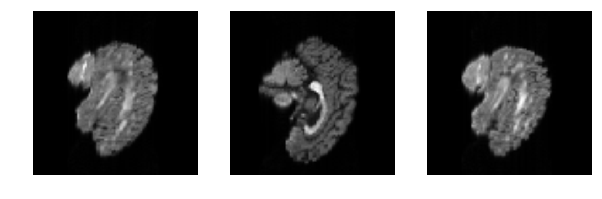

In [46]:
#X_train_preprocessed = preprocess_data_planar(X_test)

im = 60

plt.figure(figsize=(10,20))
plt.subplot(1,3,1)
plt.imshow(X_train_preprocessed[im,:,:,0],plt.cm.get_cmap('gray'), vmin=0, vmax=1); plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(X_train_preprocessed[im,:,:,1],plt.cm.get_cmap('gray'), vmin=0, vmax=1); plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(X_train_preprocessed[im,:,:,2],plt.cm.get_cmap('gray'), vmin=0, vmax=1); plt.axis('off')
plt.cm.get_cmap('gray')

y_test[im]

In [152]:
# Creates a graph.
a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Runs the op.
print(sess.run(c))

[[ 22.  28.]
 [ 49.  64.]]


In [153]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10790470086228041120
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 246415360
locality {
  bus_id: 1
}
incarnation: 3264706109546964354
physical_device_desc: "device: 0, name: TITAN X (Pascal), pci bus id: 0000:04:00.0"
]
